In [1]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\Code\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods

  Activating project at `C:\Users\KarlH\Desktop\ComputationalPhysicsMaster\Code\OrbitalNeuralMethods`
┌ Info: Precompiling OrbitalNeuralMethods [6de8678a-dd1c-461e-a987-24da1d9562b4]
└ @ Base loading.jl:1423


In [19]:
using PyFormattedStrings
import Plots as plt

## HO Basis and Spatial System

In [3]:
exact = 0.8247

0.8247

In [24]:
l = 10
ω = 0.25
basis = SpinBasis(HOBasis(l, ω))

n = 2
V = ShieldedCoulomb(0.25)
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, V);
println(f"HO Basis Ref : E = {reference_energy(system):.4f}, D = {reference_energy(system) - exact:.4f}")

HO Basis Ref : E = 1.3837, D = 0.5590


## HF

In [5]:
hf = setup_HF(system);
compute_ground_state!(hf, max_iter = 1000, tol = 1e-10)
println(f"HF  : E = {energy(hf):.4f}, D = {energy(hf) - exact:.4f}")

rhf = setup_RHF(system);
compute_ground_state!(rhf, max_iter = 1000, tol = 1e-10)
println(f"RHF : E = {energy(rhf):.4f}, D = {energy(rhf) - exact:.4f}")

HF  : E = 0.8450, D = 0.0203
RHF : E = 1.1796, D = 0.3549


In [6]:
println(hf.C[:,1][1:4])
println(hf.C[:,2][1:4])
println("These are not spin-anti-symmetric")

[0.0016773063019815638, 0.9654195818131047, 0.00024962996138401907, -4.3370355778482606e-7]
[0.0003097512203896981, -5.381573829293698e-7, 0.001726257006134819, 0.9935945002984495]
These are not spin-anti-symmetric


## CCD

In [7]:
ccd = setup_CCD(system);
compute_ground_state!(ccd, max_iter = 1000, tol = 1e-10)
println(f"CCD    : E = {energy(ccd):.4f}, D = {energy(ccd) - exact:.4f}")

ccd = setup_CCD(System(rhf));
compute_ground_state!(ccd, max_iter = 1000, tol = 1e-10)
println(f"CCD+RHF: E = {energy(ccd):.4f}, D = {energy(ccd) - exact:.4f}")

ccd = setup_CCD(System(hf));
compute_ground_state!(ccd, max_iter = 1000, tol = 1e-10)
println(f"CCD+HF : E = {energy(ccd):.4f}, D = {energy(ccd) - exact:.4f}")

CCD    : E = 1.0517, D = 0.2270
CCD+RHF: E = 0.8384, D = 0.0137
CCD+HF : E = 0.8377, D = 0.0130


## CCSD

In [8]:
ccsd = setup_CCSD(system);
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD    : E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

ccsd = setup_CCSD(System(rhf));
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD+RHF: E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

ccsd = setup_CCSD(System(hf));
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD+HF : E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

CCSD    : E = 0.8253, D = 0.0006
CCSD+RHF: E = 0.8253, D = 0.0006
CCSD+HF : E = 0.8374, D = 0.0127


In [9]:
big_system = System(n, SpinBasis(HOBasis(20, ω)), grid, V);

ccsd = setup_CCSD(big_system);
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD    : E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

CCSD    : E = 0.8250, D = 0.0003


## Convergence Acceleration

In [10]:
function how_fast(state; max_iter, tol)
    iters = 1
    old_E = energy(state)

    for i in 1:max_iter
        update!(state)

        new_E = energy(state)
        if abs(new_E - old_E) < tol
            return iters
        end
        old_E = new_E
        iters += 1
    end
    return max_iter
end

how_fast (generic function with 1 method)

In [22]:
alphas = 0:0.01:1
max_iter = 300

needed_iters_ccd = zero(alphas)
needed_iters_ccsd = zero(alphas)

for (i, alpha) in enumerate(alphas)
    ccd = setup_CCD(System(rhf), Alpha(alpha))
    needed_iters_ccd[i] = how_fast(ccd, max_iter = max_iter, tol = 1e-10)
    
    ccsd = setup_CCSD(System(rhf), Alpha(alpha))
    needed_iters_ccsd[i] = how_fast(ccsd, max_iter = max_iter, tol = 1e-10)
end

CCD min: α = 0.65 iters = 39.0
CCSD min: α = 0.61 iters = 55.0


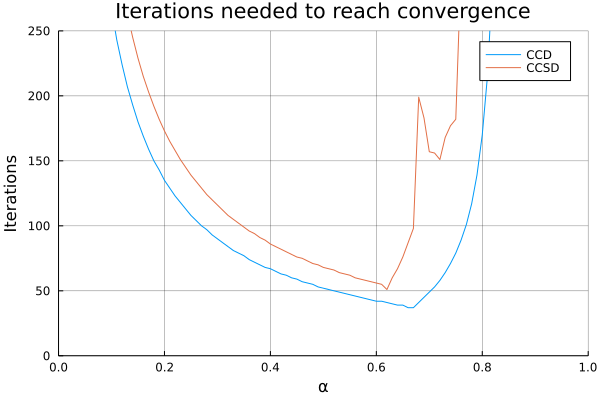

In [23]:
ccd_min = argmin(needed_iters_ccd[2:end])
ccsd_min = argmin(needed_iters_ccsd[2:end])
println("CCD min: α = $(alphas[ccd_min]) iters = $(needed_iters_ccd[ccd_min])")
println("CCSD min: α = $(alphas[ccsd_min]) iters = $(needed_iters_ccsd[ccsd_min])")

plt.plot(yrange = (0, 250), xrange=(0,1), gridalpha=0.5, xlabel="α", ylabel="Iterations", title="Iterations needed to reach convergence")
plt.plot!(alphas[2:end], needed_iters_ccd[2:end], label="CCD")
plt.plot!(alphas[2:end], needed_iters_ccsd[2:end], label="CCSD")
plt.savefig("alpha_iters.png")
plt.plot!()

## Energy/Iter

In [14]:
ccsd = setup_CCSD(System(rhf));
println(how_fast(ccsd, max_iter=100, tol=1e-10))
ccd = setup_CCD(System(rhf));
println(how_fast(ccd, max_iter=100, tol=1e-10))

17
15


In [15]:
ccsd = setup_CCSD(System(rhf));
ccd = setup_CCD(System(rhf));

iters = 20
ccd_energies = zeros(iters+1)
ccsd_energies = zeros(iters+1)

ccd_energies[1] = energy(ccd)
ccsd_energies[1] = energy(ccsd)
for i in 2:iters+1
    update!(ccd)
    update!(ccsd)
    ccd_energies[i] = energy(ccd)
    ccsd_energies[i] = energy(ccsd)
end

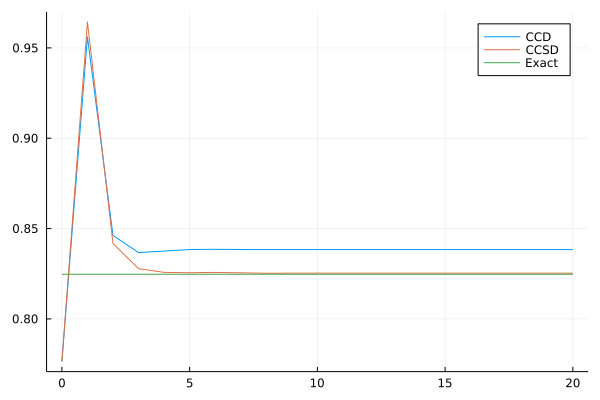

In [21]:
plt.plot(xlabel="Iterations", ylabel="Energy", )
plt.plot!(0:iters, ccd_energies, label="CCD")
plt.plot!(0:iters, ccsd_energies, label="CCSD")
plt.plot!([0, 20], [exact, exact], label="Exact")
plt.savefig("diis_conv.png")
plt.plot!()